In [52]:
from datamatrix import (
    functional as fnc,
    DataMatrix,
    operations as ops,
    io
)
from forrestprf import stimulus, data, fitting, plotting
import multiprocessing
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [5]:
SUBJECTS = 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16 ,17, 18, 19, 20

## Create PRF maps

For every participant and ROI, create a PRF map, and save it as a pickled dict.

In [7]:
def prf_map(sub_roi):

    sub, roi = sub_roi
    prf_map = fitting.prf_map(
        stimulus.retinotopic_mapping_stim(4),
        data.subject_data(sub),
        data.juelich_mask(data.ROI_JUELICH[roi]),
        npass=3
    )
    prf_map.sub = sub
    prf_map.roi = roi
    print(prf_map)
    return prf_map


with multiprocessing.Pool(2) as pool:
    maps = pool.map(prf_map, itertools.product(SUBJECTS, data.ROI_JUELICH))

PRF mapping (pass 1)
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 2)
PRF mapping (pass 3)
PRF mapping (pass 3)
+---+---------+---------+---------+---------+-----+-----+
| # | prf_err |  prf_sd |  prf_x  |  prf_y  | roi | sub |
+---+---------+---------+---------+---------+-----+-----+
| 0 | [nifti] | [nifti] | [nifti] | [nifti] |  V1 |  1  |
+---+---------+---------+---------+---------+-----+-----+
+---+---------+---------+---------+---------+-----+-----+
| # | prf_err |  prf_sd |  prf_x  |  prf_y  | roi | sub |
+---+---------+---------+---------+---------+-----+-----+
| 0 | [nifti] | [nifti] | [nifti] | [nifti] |  V1 |  3  |
+---+---------+---------+---------+---------+-----+-----+
PRF mapping (pass 1)
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 2)
PRF mapping (pass 3)
PRF mapping (pass 3)
+---+---------+---------+---------+---------+-----+-----+
| # | prf_err |  prf_sd |  prf_x  |  prf_y  | roi | sub |
+---+---------+---------+---------+---------+-----+-

/home/sebastiaan/git/studyforrest-prf/forrestprf/fitting.py:76: RuntimeWarning: invalid value encountered in true_divide
  bold /= bold.max()


+---+---------+---------+---------+---------+-----+-----+
| # | prf_err |  prf_sd |  prf_x  |  prf_y  | roi | sub |
+---+---------+---------+---------+---------+-----+-----+
| 0 | [nifti] | [nifti] | [nifti] | [nifti] |  V1 |  2  |
+---+---------+---------+---------+---------+-----+-----+
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 1)
PRF mapping (pass 3)
PRF mapping (pass 2)
+---+---------+---------+---------+---------+-----+-----+
| # | prf_err |  prf_sd |  prf_x  |  prf_y  | roi | sub |
+---+---------+---------+---------+---------+-----+-----+
| 0 | [nifti] | [nifti] | [nifti] | [nifti] |  V2 |  4  |
+---+---------+---------+---------+---------+-----+-----+
PRF mapping (pass 3)


/home/sebastiaan/git/studyforrest-prf/forrestprf/fitting.py:76: RuntimeWarning: invalid value encountered in true_divide
  bold /= bold.max()


+---+---------+---------+---------+---------+-----+-----+
| # | prf_err |  prf_sd |  prf_x  |  prf_y  | roi | sub |
+---+---------+---------+---------+---------+-----+-----+
| 0 | [nifti] | [nifti] | [nifti] | [nifti] |  V2 |  2  |
+---+---------+---------+---------+---------+-----+-----+
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 3)
+---+---------+---------+---------+---------+-----+-----+
| # | prf_err |  prf_sd |  prf_x  |  prf_y  | roi | sub |
+---+---------+---------+---------+---------+-----+-----+
| 0 | [nifti] | [nifti] | [nifti] | [nifti] |  V3 |  4  |
+---+---------+---------+---------+---------+-----+-----+
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 3)
+---+---------+---------+---------+---------+-----+-----+
| # | prf_err |  prf_sd |  prf_x  |  prf_y  | roi | sub |
+---+---------+---------+---------+---------+-----+-----+
| 0 | [nifti] | [nifti] | [nifti] | [nifti] |  V3 |  2  |
+---+---------+---------+---------+---------+-----+-----+
PRF 

In [54]:
def flatten(n, minval=-np.inf, maxval=np.inf):
    
    a = n.get_data().flatten()
    return a[~np.isnan(a) & (a >= minval) & (a <= maxval)]


dm = DataMatrix()
for sdm in maps:
    dm <<= sdm
dm.rf_size = dm.prf_sd @ (
    lambda img: np.nanmean(
        flatten(img, minval=1, maxval=60)
    )
)
io.writepickle(dm, 'outputs/prf-dm.pkl')

/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.
/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


# Plot RFs

/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.
/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


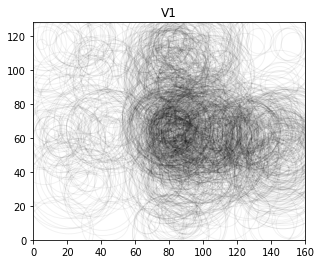

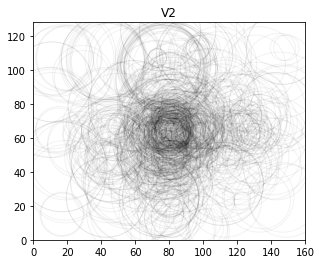

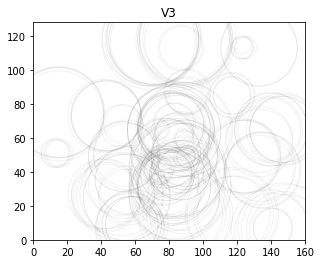

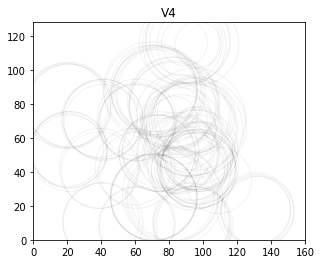

In [39]:
for roi, rdm in ops.split((dm.sub == 1).roi):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    for row in rdm:
        for x, y, sd in zip(
            data(row.prf_x, minval=4, maxval=156),
            data(row.prf_y, minval=4, maxval=124),
            data(row.prf_sd, minval=1, maxval=60),
        ):
            ax.add_artist(
                plt.Circle(
                    xy=(x, y),
                    radius=sd/2,
                    alpha=.05,
                    fill=False
                )
            )
    plt.title(roi)
    plt.xlim(0, 160)
    plt.ylim(0, 128)
    plt.show()

# RF sizes per ROI

Text(0.5, 0, 'ROI')

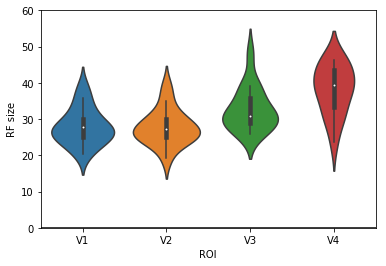

In [50]:
ax = sns.violinplot(x='roi', y='rf_size', data=dm)
ax.axhline(0, color='black')
plt.ylim(0, 60)
plt.ylabel('RF size')
plt.xlabel('ROI')

## Correlations between RF eccentricity, roi, and size

In [ ]:
from datamatrix import operations as ops

dm = DataMatrix()
for sub, sub_maps in maps.items():
    for roi, prf_map in sub_maps.items():
        x, y, sd, err = prf_map.params
        err = err[~np.isinf(err)]
        sdm = DataMatrix(length=len(x))
        sdm.roi = roi
        sdm.sub = sub
        sdm.x = x
        sdm.y = y
        sdm.sd = sd
        sdm.err = err
        dm <<= sdm
dm.ecc = ((dm.x - 80) ** 2 + (dm.y - 64) **2) ** .5
dm = ops.auto_type(dm)

In [ ]:
from datamatrix.rbridge import lme4
lme4.lmer(dm, 'sd ~ ecc + roi + (1+ecc+roi|sub)')

In [ ]:
for roi in data.ROI_JUELICH:
    sns.scatterplot(x='ecc', y='sd', data=(dm.roi == roi), marker='.')
    plt.title(roi)
    plt.xlabel('Eccentricity')
    plt.ylabel('RF size')
    plt.show()